In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/yermaand/audio-nn'

In [3]:
from src import *

def get_melkwargs(params):
    return {
        "n_fft": params.n_fft,
        "n_mels": params.n_mels,
        "hop_length": params.hop_length
    }

In [7]:
files = [
    '15_RX100',
    '15_Mobius_aligned_RX100',
    '15_iphone_aligned_RX100'
]

config = load_config_locally('020_RX100_resized_128/0')

videos = []
for file in files:
    video = Video(file, config)
    videos.append(video)

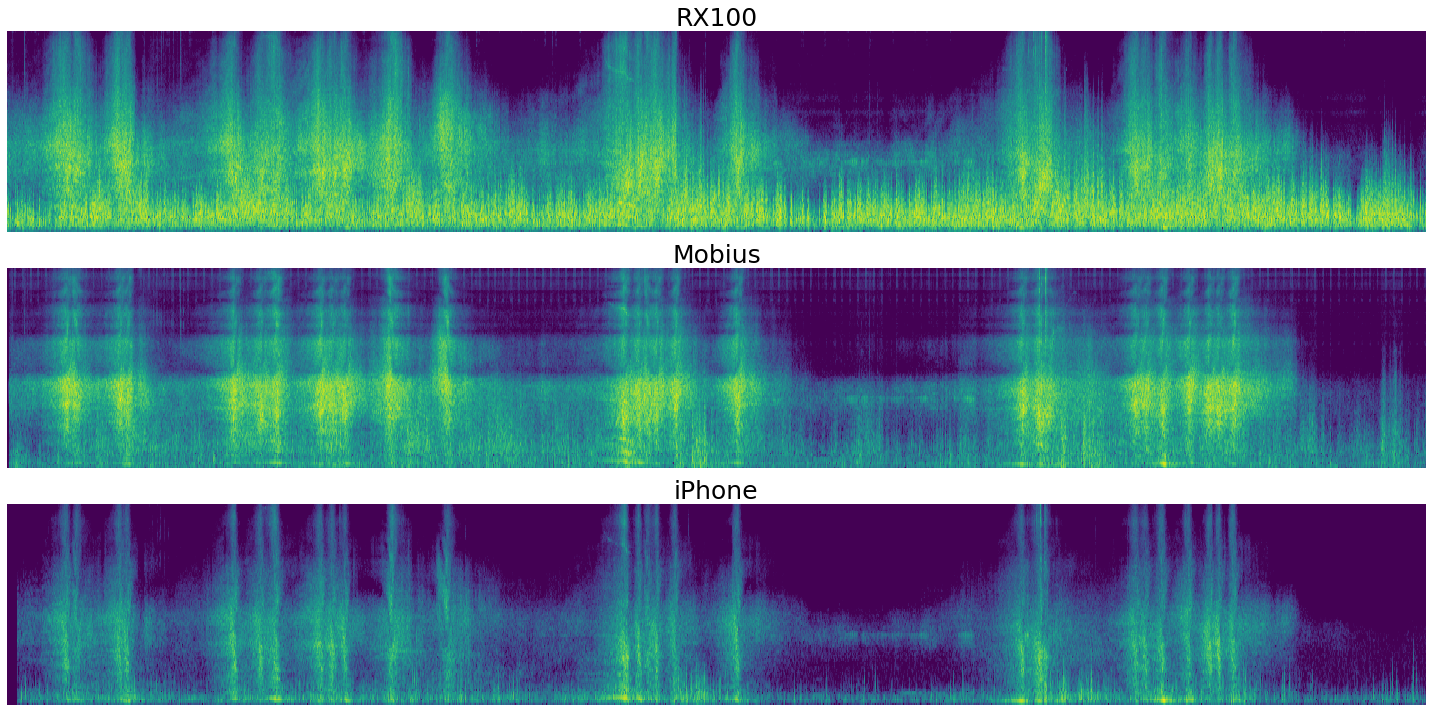

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

till_time = 3 * 60

names = ['RX100', 'Mobius', 'iPhone']

for i, (video, name) in enumerate(zip(videos, names)):
    signal = crop_signal(video.signal, config.sr, 0, till_time)
    transform_signal = torchaudio.transforms.MelSpectrogram(sample_rate=config.sr, **get_melkwargs(config))
    transform_power = torchaudio.transforms.AmplitudeToDB(top_db=70)
    features = transform_signal(signal)
    features = transform_power(features)
    axes[i].pcolormesh(features)
    axes[i].set_title(name, fontsize=25)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('plots/feature_comparison.png', dpi=150)